# Estimating $k_j$

>Next, I'd get it working with less and less information assumed to be known. You could either start inferring the participant's stage of disease or the order for biomarkers next. I'd probably do the participant's state of disease.

>For the stage of disease for a participant, I'd do probably derive a gibbs sampling step by calculating each stage's relative likelihood based on the probabilities of the biomarker values ASSUMING they are at that stage. Then you normalize and sample from that discrete distribution.  

## Known $\theta$ and $\phi$

First, let us assume that we know $\theta$ and $\phi$. We also know at which disease stage a biomarker is affected. Basically, in the `data` below, we do not have these two columns: `k_j` and `affected_or_not`. 

For each participant, I will iterate through all possible stages. For each stage, I will calculate the likelihood of seeing the observed biomarker sequence of values using the following formula:

$$p(X_{j} | S , z_j = 1, k_j) = \prod_{i=1}^{k_j}{p(X_{S(i)j} \mid \theta_n )} \prod_{i=k_j+1}^N{p(X_{S(i)j} \mid \phi_n)}$$

Then the stage associated with the maximum likelihood will be the estimated disease stage for this participant. 


In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,12.543832,9,10,not_affected
1,0,1,10.961353,7,10,not_affected
2,0,2,14.319107,3,10,not_affected
3,0,3,13.284483,4,10,not_affected
4,0,4,11.235334,1,10,not_affected


In [2]:
theta_phi = pd.read_csv('data/means_vars.csv')
theta_phi.head()

,biomarker,theta_mean,theta_var,phi_mean,phi_var
0,0,1.0,0.3,12.0,1.3
1,1,3.0,0.5,11.0,2.4
2,2,5.0,0.2,14.0,1.4
3,3,6.0,1.3,16.0,0.9
4,4,8.0,3.3,18.0,1.5


In [3]:
def compute_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the given measurement data
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of the given measurement. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a number 
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    var = biomarker_params['theta_var'][0] if affected else biomarker_params['phi_var'][0]
    sigma = np.sqrt(var)
    return np.exp(-(measurement - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [4]:
# Disable scientific notation
np.set_printoptions(suppress=True)

biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 1000
num_stages = len(data.S_n.unique())
estimated_stage_dic = {}
actual_stage_dic = {}

# stages = np.random.randint(0, num_stages, len(participants))

for p in participants:
    p_data = data[data.participant == p].reset_index(drop=True)
    actual_stage_dic[p] = p_data.k_j[0]
    stage_likelihood = np.zeros(num_stages)
    # assume participant is in this stage; compute the likelihood of seeing 
    # this sequence of observed biomarker measuremen
    # [0, 9]
    for k in range(num_stages):
        likelihood = 1
        for biomarker in biomarkers:
            biomaker_data = p_data[p_data.Biomarker == str(biomarker)].reset_index(drop=True)
            measurement = biomaker_data.measurement[0]
            biomarker_stage = biomaker_data.S_n[0]
            affected = k >= biomarker_stage
            # the final updated likelihood is the likelihood of seeing 
            # this sequence of data of the total number of biomarkers 

            # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
            likelihood *= compute_likelihood(
                theta_phi, biomarker, affected, measurement
            )

            # if the participant is in this stage, what is the likelihood of seeing this 
            # sequence of values
            stage_likelihood[k] = likelihood
    # if p % 10 == 0:
    #     print(stage_likelihood)
    # has_duplicates = len(stage_likelihood) != len(set(stage_likelihood))
    # print(has_duplicates)
    max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
    estimated_stage_dic[p] = max_likelihood_stage           

In [5]:
estimated_stages = np.array(list(estimated_stage_dic.values()))
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

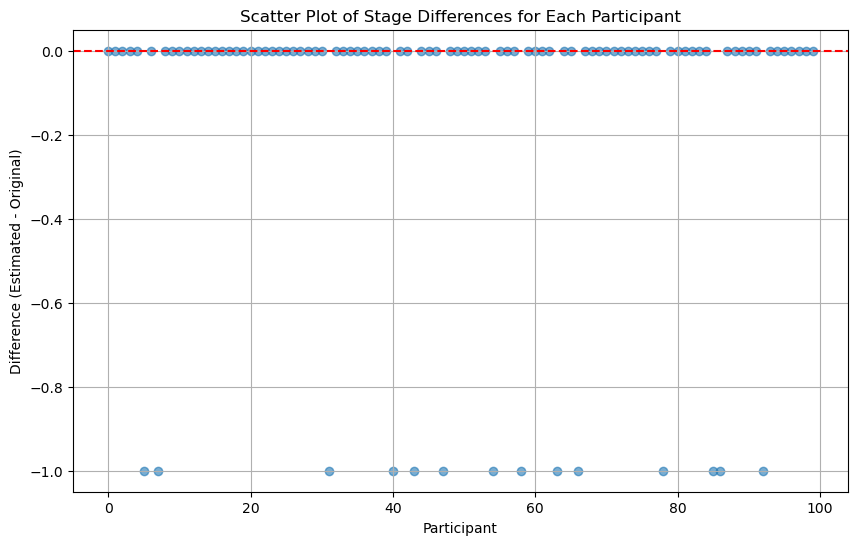

In [6]:
# 2. Scatter Plot of the Differences at each index
plt.figure(figsize=(10, 6))
plt.scatter(range(100), differences, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Scatter Plot of Stage Differences for Each Participant")
plt.xlabel("Participant")
plt.ylabel("Difference (Estimated - Original)")
plt.grid(True)
plt.show()


## Unknown $\theta$ and $\phi$

Suppose in the following data, we do not have access to the parameters for biomarker value distributions; i.e., we do not know $\theta$ and $\phi$. 

In [7]:
data.head()

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,12.543832,9,10,not_affected
1,0,1,10.961353,7,10,not_affected
2,0,2,14.319107,3,10,not_affected
3,0,3,13.284483,4,10,not_affected
4,0,4,11.235334,1,10,not_affected


In [8]:
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have.head()

,Biomarker,participant,measurement,S_n
0,0,0,12.543832,10
1,0,1,10.961353,10
2,0,2,14.319107,10
3,0,3,13.284483,10
4,0,4,11.235334,10


In [9]:
def fill_up_data_we_have(data_we_have, participant_stages):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on participant_stages
    '''
    participant_stage_dic = dict(zip(np.arange(0,len(participants)), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [10]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''
    data: a vector of measurements. It is of a specific biomarker and of a specific type (affected, or not affected)
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    return mu_posterior_mean, sigma_squared_posterior_mean

In [11]:
def get_estimate_means_vars_df(biomarkers, data_we_have):
    '''To get estimated parameters, return a pd.DataFrame
    Input:
    - biomarkers: 0-9
    - data_we_have: participants data with initial and updated participant_stages

    Output: 
    - estimate_means_vars_df, just like means_vars_df, containing the estimated mean and var for 
      distribution of biomarker values when the biomarker is affected and not affected

    Special not: in the edge case of a biomarker indicating stage 1. Note that a participant's disease stage 
    might be 0. Therefore, for this biomarker, it has both affected and not affected cases. 
    '''
    # empty list of dictionaries to store the estimates 
    means_vars_estimate_dict_list = []
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.Biomarker == str(biomarker)) & (
            data_we_have.affected == affected)]
            data = np.array(data_full.measurement)
            mu_estimate, var_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_var'] = var_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_var'] = var_estimate
        means_vars_estimate_dict_list.append(dic)
    estimate_means_vars_df = pd.DataFrame(means_vars_estimate_dict_list)
    return estimate_means_vars_df 

In [12]:
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 3
num_stages = 10 
# initialize participant_stages 
# note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
participant_stages = np.random.randint(low = 0, high = num_stages+1, size = len(participants))
participant_stages

array([ 6, 10, 10,  0,  3,  4,  7,  7,  6,  9,  7,  4,  0,  0,  2, 10,  9,
        3,  9, 10,  9, 10,  2,  1,  9,  0,  4,  8,  2,  6,  3,  7,  3, 10,
        6,  3,  0,  0, 10,  3,  5,  7,  2,  2,  8,  9,  1,  9,  1,  2,  7,
        5,  4,  7,  9,  7,  7,  5,  3,  2,  7,  8,  5, 10, 10,  3,  0,  1,
        8,  6,  3,  8,  1,  7,  2,  7,  0,  2,  7,  4,  6,  8,  9,  1,  7,
        2,  5,  2,  3,  9,  1,  6,  4,  7,  5,  1,  2,  7,  0,  7])

In [13]:
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 4
num_stages = 10 
# initialize participant_stages 
# note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
participant_stages = np.random.randint(low = 0, high = num_stages+1, size = len(participants))

for i in range(num_iterations):
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages)
    estimate_means_vars_df = get_estimate_means_vars_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        stage_likelihood = np.zeros(num_stages)
        for k in range(num_stages):
            likelihood = 1
            for biomarker in biomarkers:
                # biomarker data for this participant
                p_biomaker_data = p_data[
                    p_data.Biomarker == str(biomarker)
                ].reset_index(drop=True)
                measurement = p_biomaker_data.measurement[0]
                biomarker_stage = p_biomaker_data.S_n[0]
                affected = k >= biomarker_stage

                # the final updated likelihood is the likelihood of seeing 
                # this sequence of data of the total number of biomarkers
                # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
                likelihood *= compute_likelihood(
                    estimate_means_vars_df, biomarker, affected, measurement
                )
                # if the participant is in this stage, what is the likelihood of seeing this 
                # sequence of values
                stage_likelihood[k] = likelihood
        max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
        # update participant_stages
        participant_stages[p] = max_likelihood_stage  

/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


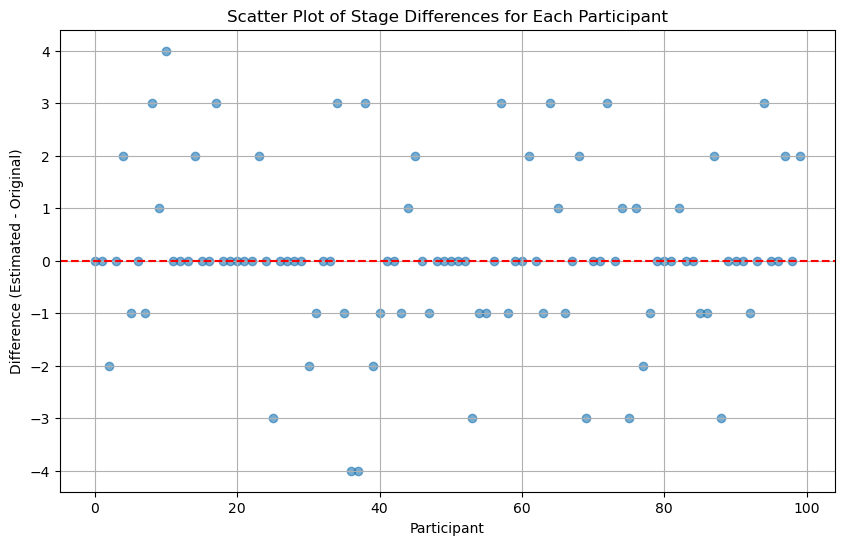

In [14]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

# 2. Scatter Plot of the Differences at each index
plt.figure(figsize=(10, 6))
plt.scatter(range(100), differences, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Scatter Plot of Stage Differences for Each Participant")
plt.xlabel("Participant")
plt.ylabel("Difference (Estimated - Original)")
plt.grid(True)
plt.show()